Consider a linear positioning system. Its dynamics is described in the differential
equation
$$ \ddot{y}(t) + \dot{y}(t) + 2y(t) = u(t) $$

where $y(t)$ is the position, $\dot{y}(t)$ the velocity $\ddot{y}(t)$ the acceleration and u(t) the input force

There are sensors that measure the position y(t) and the velocity dy/dt. The goal
is to design an automatic system with feedback such that the position can be
commanded to move from one location to another. The position and the velocity
are available for the feedback design, if you choose to use any of them.
The design criteria are based on the system's unit step response. They are:

1) Zero steady-state error as the position is commanded to move to a new location.

2) The overshoot is limited to 5%.

3) The positioning settles within 2% of the target step in 1 second

Your task is to design the automated system with two approaches, one by transfer
functions and another by state-space model.

Present your design with (a) numerical specifics of the elements,
(b) block diagrams that show the configuration of the design, and (c) simulated
step responses to show the extent to which the design meets the criteria.

# State space


$$ \ddot{y}(t) + \dot{y}(t) + 2y(t) = u(t) $$
$$x_1 = y(t)$$
$$x_2 = \dot{x_1} = \dot{y}(t)$$
$$ x_3 = \dot{x_2} =\ddot{y}(t) $$

re written
$$ \dot{x_1} = 0 x_1 + 1 x_2 + 0 u(t)$$
$$ \dot{x_2} = -2x_1 + -3 x_2 + 1 u(t)$$
state space equations 

The goal is to be able to change the position so the output of ht system is x1

$$ \begin{pmatrix}
 \dot{x_1} \\
 \dot{x_2} 
 \end{pmatrix} = \begin{pmatrix}
 0 & 1 \\
 -2 & -3 
 \end{pmatrix} \begin{pmatrix}
 x_1 \\
 x_2 
 \end{pmatrix} + \begin{pmatrix}
 0 \\
 1 
 \end{pmatrix}[u] $$

$$ y = \begin{pmatrix}
 1 & 0 
 \end{pmatrix}\begin{pmatrix}
 x_1 \\
 x_2 
 \end{pmatrix} $$

I'll use constant gains to fulfill desired requirements

![picture](constant_gain.jpg)

I tried a few poles and found that $-10 \pm 2i$ worked

In [1]:
import numpy as np
import control as ctl
import control.matlab as cnt
import matplotlib.pyplot as plt
%matplotlib inline

# original system
A = np.array([[0,   1],
              [-2, -3]])

B = np.array([[0],
              [1]])

C = np.array([1, 0])

D = 0



ORIGINAL poles 

[-1. -2.]

ORIGINAL stepinfo 

{'RiseTime': 2.571571571571572, 'SettlingTime': 4.51951951951952, 'SettlingMin': 0.44937395164782773, 'SettlingMax': 0.4990885337988053, 'Overshoot': 0.0, 'Undershoot': 0.0, 'Peak': 0.4990885337988053, 'PeakTime': 7.0, 'SteadyStateValue': 0.4990885337988053}


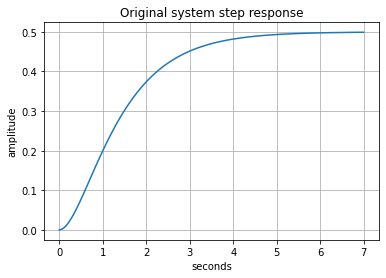

In [2]:
original_ss = ctl.ss(A,B,C,D)
print('\nORIGINAL poles \n')
print(ctl.pole(original_ss))
print('\nORIGINAL stepinfo \n')
print(ctl.step_info(original_ss))
T, yout = ctl.step_response(original_ss)
plt.grid(True)
plt.title('Original system step response')
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.plot(T,yout)

plt.show()

A = [[   0.    1.]
 [-104.  -20.]]

B = [[  0.        ]
 [104.40684068]]

C = [[1. 0.]]

D = [[0.]]

FINAL poles 

[-10.+2.j -10.-2.j]

 K is equal to 104.4068406840684


FINAL step info
{'RiseTime': 0.3153153153153156, 'SettlingTime': 0.5290290290290296, 'SettlingMin': 0.8994102337846175, 'SettlingMax': 0.999245687618023, 'Overshoot': 0.0, 'Undershoot': 0.0, 'Peak': 0.999245687618023, 'PeakTime': 0.7000000000000007, 'SteadyStateValue': 0.999245687618023}


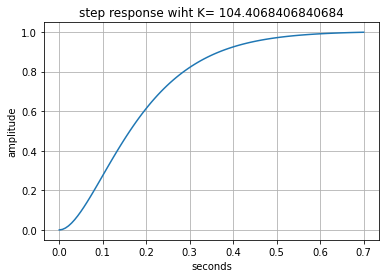

In [3]:
# I want the poles to be -10+/-2i this should give appropriate rise time
# it will find a value of input gain where overshoot is very very close to 0
poles = [-10+2j, -10-2j]

input_gain_array = np.linspace(1,1000,10000)

for i in input_gain_array:
    
    B = np.array([[0],
                  [i]])
    
    K = ctl.place(A,B,poles)
    closed_loop = A - B*K
    final_ss = ctl.ss(closed_loop,B,C,D)
    y = ctl.step_info(final_ss)
    if (i == 1000):
        print('ERROR: choose a new pole')
    if (y.get('Overshoot') < 5.0 and y.get('SettlingTime') < 2.0 and  \
        abs(y.get('SteadyStateValue') - 1) <= 0.001):
        break

T, yout = ctl.step_response(final_ss)
print(final_ss)
print('FINAL poles \n')
print(ctl.pole(final_ss))
print('\n K is equal to ' +str(i) +'\n')
print('\nFINAL step info')
print(y)
plt.title('step response wiht K= ' + str(i))
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.grid(True)
plt.plot(T,yout)

# transfer function

$$ \ddot{y}(t) + \dot{y}(t) + 2y(t) = u(t) $$
looking at the laplace transform table with inital conditions equal to zero

$$\text{L}\{\ddot{y}(t)\} = s^2 Y(s) $$
$$ \text{L}\{\dot{y}(t)\} = sY(s) $$
$$ \text{L} \{2y(t)\} = 2Y(S) $$
$$\text{L}\{u(t)\} = U(s) $$


giving

$$ Y(S) (s^2 + 3s + 2) = U(s) $$

$$ \frac{Y(s)}{U(s)} = \frac{1}{s^2 + 3s + 2} $$

Ill use a PID to solve this one, note that only position and velocity are available to us so in my code I will not use the the integral



$$ T_f = \frac{Gc*Gp}{1+Gc*Gp} $$
$$ Gc = \frac{kd (s^2) + kp(s) + ki}{s} $$
$$ T_f = \frac{\frac{kd (s^2) + kp(s) + ki}{s} * \frac{1}{s^2 + 3s + 2}}{1 + \frac{kd (s^2) + kp (s) + ki}{s}* \frac{1}{s^2 + 3s + 2}} $$

which reduces according to 

https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlPID

$$ T_f = \frac{k_d s^2 + k_p s + k_i}{s^3 + (k_d + 3)s^2 + (k_p + 2)s + ki}  $$

Now that I have a transfer function i can use python to find the values of kd kp (ki will remain zero)

![picture](pid.jpg)

**once again ki = 0**

ORIGINAL transfer function


      1
-------------
s^2 + 3 s + 2



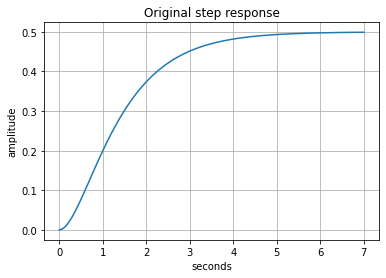

In [4]:
num = 1
den = [1, 3, 2]
original_tf = ctl.tf(num,den)

print('ORIGINAL transfer function\n')
print(original_tf)
T, yout = ctl.step_response(original_tf)
plt.grid(True)
plt.title('Original step response')
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.plot(T,yout)

kp = 10000.0

kd = 409.1224489795918

FINAL transfer function


   409.1 s^2 + 1e+04 s
-------------------------
s^3 + 412.1 s^2 + 1e+04 s

FINAL stepinfo
{'RiseTime': 0.004870340717044046, 'SettlingTime': 0.044915364390517305, 'SettlingMin': 0.9095794173608415, 'SettlingMax': 1.0398112071436438, 'Overshoot': 3.995869392036325, 'Undershoot': 0.0, 'Peak': 1.0398112071436438, 'PeakTime': 0.01542274560397281, 'SteadyStateValue': 0.9998581801589028}



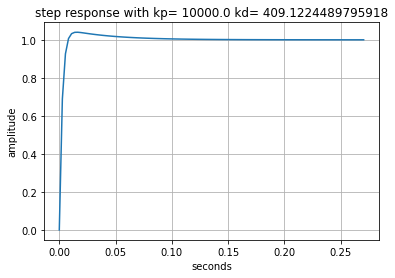

In [5]:
ki = 0
kp_range = np.linspace(1,10000)

kd_range = np.linspace(1,10000)

for kp in kp_range: 
    for kd in kd_range: 
        num = [kd,kp,ki]
        den = [1, kd+3,kp+2,ki]
        final_tf = ctl.tf(num,den)
        y = ctl.step_info(final_tf)
        if (y.get('Overshoot') < 5.0 and y.get('SettlingTime') < 2.0 and  \
            abs(y.get('SteadyStateValue') - 1) <= 0.001):
            break
print('kp = ' + str(kp) + '\n')
print('kd = ' + str(kd) + '\n')
print('FINAL transfer function\n')
print(final_tf)
print("FINAL stepinfo")
print(str(y) + '\n')
T, yout = ctl.step_response(final_tf)
plt.title('step response with kp= ' +str(kp)+ ' kd= ' +str(kd))
plt.xlabel('seconds')
plt.ylabel('amplitude')
plt.grid(True)
plt.plot(T,yout)